In [6]:
# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor, xgb_model #had to pip install xgboost
HOME = os.path.expanduser('~')

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

XGBoost development script, cuda


In [7]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'

df = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)
df.head()

Concatenating 14 for the model dataframe development.


  0%|          | 0/14 [00:00<?, ?it/s]

There are 305566 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 99 for the model dataframe development.


  0%|          | 0/99 [00:00<?, ?it/s]

There are 2222453 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2698389 datapoints for model training/testing in the overall modeling domain.


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,ns_6_week_mean,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,swe_cm,region,region_class
0,5152,SouthernRockies_300M_37.322_-106.366,2015-04-06,37.322,-106.366,3000,5,191,16.5,18.5,...,3.092308,1.755319,2.339494,2.055441,1.627859,1.494303,0.000000,0.000000,SouthernRockies,1
1,19438,SouthernRockies_300M_37.131_-106.326,2015-04-06,37.131,-106.326,3305,4,249,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.157039,SouthernRockies,1
2,19437,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.131,-106.329,3283,18,27,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.042090,SouthernRockies,1
3,19436,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.131,-106.331,3233,15,249,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.000009,SouthernRockies,1
4,19435,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.131,-106.334,3266,28,232,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.000000,SouthernRockies,1


In [8]:
df.columns

Index(['index', 'cell_id', 'Date', 'cen_lat', 'cen_lon', 'Elevation_m',
       'Slope_Deg', 'Aspect_Deg', 'ns_1', 'ns_2', 'ns_3', 'ns_4', 'ns_5',
       'ns_6', 'VIIRS_SCA', 'hasSnow', 'season_precip_cm', 'DOS', 'WY_week',
       'ns_1_week_mean', 'ns_2_week_mean', 'ns_3_week_mean', 'ns_4_week_mean',
       'ns_5_week_mean', 'ns_6_week_mean', 'Seasonal_ns_1_rel',
       'Seasonal_ns_2_rel', 'Seasonal_ns_3_rel', 'Seasonal_ns_4_rel',
       'Seasonal_ns_5_rel', 'Seasonal_ns_6_rel', 'swe_cm', 'region',
       'region_class'],
      dtype='object')

# Data Processing

In [9]:
#clean the data
df = dataprocessor.data_clean(df, regionlist)
df.head()

#temporary for seasonality relationship
df.fillna(1, inplace = True)

#convert dates to datetime format
df.Date = pd.to_datetime(df.Date)

input_columns = [
            'cen_lat',	
            'cen_lon',	
            'Elevation_m',	
            'Slope_Deg',	
            'Aspect_Deg',	
            'ns_1',	
            'ns_2',	
            'ns_3',	
            'ns_4',	
            'ns_5',	
            'ns_6',	
            'VIIRS_SCA', 
            'hasSnow',
            'season_precip_cm',
            'region_class',
            'DOS', 
            'WY_week',
            'ns_1_week_mean', 
            'ns_2_week_mean', 
            'ns_3_week_mean', 
            'ns_4_week_mean',
            'ns_5_week_mean', 
            'ns_6_week_mean', 
            'Seasonal_ns_1_rel',
            'Seasonal_ns_2_rel',
            'Seasonal_ns_3_rel', 
            'Seasonal_ns_4_rel',
            'Seasonal_ns_5_rel', 
            'Seasonal_ns_6_rel'
]

years = False
splitratio = 0.33
test_years = [2019]
target = 'swe_cm'

#fit a scaler,save, and scale the training data
x_train, y_train, x_test, y_test = dataprocessor.xgb_processor(
                                                    regionlist,
                                                      df, 
                                                      years, 
                                                      splitratio,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

The provided data contains 2698389 data points, of which 383245 locations/timesteps show no SWE and VIIRS fsca > 20%
275006 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
150 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
183 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 2039955 datapoints for model training/testing.


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,ns_6_week_mean,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,swe_cm,region,region_class
0,5152,SouthernRockies_300M_37.322_-106.366,2015-04-06,37.322,-106.366,3000,5,191,16.5,18.5,...,3.092308,1.755319,2.339494,2.055441,1.627859,1.494303,0.000000,0.000000,SouthernRockies,1
1,19437,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.131,-106.329,3283,18,27,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.042090,SouthernRockies,1
2,19436,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.131,-106.331,3233,15,249,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.000009,SouthernRockies,1
3,19435,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.131,-106.334,3266,28,232,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.000000,SouthernRockies,1
4,19434,SouthernRockies_300M_37.131_-106.337,2015-04-06,37.131,-106.337,3290,16,18,46.2,0.0,...,26.230769,2.055441,0.000000,1.755319,2.339494,2.372538,1.627859,0.000000,SouthernRockies,1


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,ns_6_week_mean,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,swe_cm,region,region_class
248246,2,Southwest_300M_38.182_-119.597,2013-04-03,38.182,-119.597,1706,7,36,113.1,124.5,...,12.512815,2.489418,2.775875,0.000000,0.035153,2.156931,3.820084,66.867477,Southwest,2
248247,5516,Southwest_300M_38.015_-119.561,2013-04-03,38.015,-119.561,1835,16,169,75.5,113.1,...,21.782141,2.117127,2.489418,1.756746,1.613696,1.941113,2.345959,48.456591,Southwest,2
248248,5515,Southwest_300M_38.015_-119.564,2013-04-03,38.015,-119.564,1839,11,56,75.5,113.1,...,21.782141,2.117127,2.489418,1.756746,1.613696,1.941113,2.345959,53.630471,Southwest,2
248249,5514,Southwest_300M_38.015_-119.567,2013-04-03,38.015,-119.567,1841,5,127,75.5,113.1,...,44.850723,2.117127,2.489418,1.756746,1.613696,1.941113,2.775875,49.717703,Southwest,2
248250,5513,Southwest_300M_38.015_-119.57,2013-04-03,38.015,-119.570,1850,8,120,75.5,113.1,...,14.630779,2.117127,2.489418,1.756746,1.613696,2.775875,1.941113,48.634857,Southwest,2


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,ns_6_week_mean,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,swe_cm,region,region_class
1901057,85184,Northwest_300M_47.496_-123.881,2016-02-08,47.496,-123.881,651,65,257,93.0,72.9,...,7.371429,2.990354,3.000000,3.402946,3.787066,0.000000,5.684109,0.000000,Northwest,3
1901058,28390,Northwest_300M_47.892_-123.622,2016-02-08,47.892,-123.622,575,36,146,72.9,93.0,...,7.371429,3.000000,2.990354,3.402946,2.683908,3.787066,5.684109,133.371216,Northwest,3
1901059,28391,Northwest_300M_47.892_-123.619,2016-02-08,47.892,-123.619,517,33,118,72.9,93.0,...,7.371429,3.000000,2.990354,3.402946,2.683908,3.787066,5.684109,93.470695,Northwest,3
1901060,28392,Northwest_300M_47.892_-123.616,2016-02-08,47.892,-123.616,461,33,113,72.9,93.0,...,7.371429,3.000000,2.990354,3.402946,2.683908,3.787066,5.684109,83.744812,Northwest,3
1901061,28393,Northwest_300M_47.892_-123.614,2016-02-08,47.892,-123.614,398,29,137,72.9,93.0,...,7.371429,3.000000,2.990354,3.402946,2.683908,3.787066,5.684109,80.450775,Northwest,3


# Train Model

Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[CV 3/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-10.665 total time= 4.4min
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-9.515 total time= 5.8min
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=100;, score=-9.562 total time= 6.3min
[CV 3/3] END eta=0.1, max_depth=4, n_estimators=100;, score=-8.625 total time= 7.6min
[CV 2/3] END eta=0.1, max_depth=4, n_estimators=100;, score=-8.006 total time=10.8min
[CV 1/3] END eta=0.1, max_depth=4, n_estimators=100;, score=-8.002 total time=10.8min
[CV 3/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-9.743 total time=16.2min
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-9.056 total time=16.7min
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=300;, score=-9.261 total time=19.1min
[CV 1/3] END eta=0.1, max_depth=4, n_estimators=300;, score=-7.264 total time=23.2min
[CV 1/3] END eta=0.1, max_depth=2, n_estimators=500;, score=-8.966 total time=23.8min
[CV 2/3] END eta=0.1, max_depth=2, n_estimators=500;,

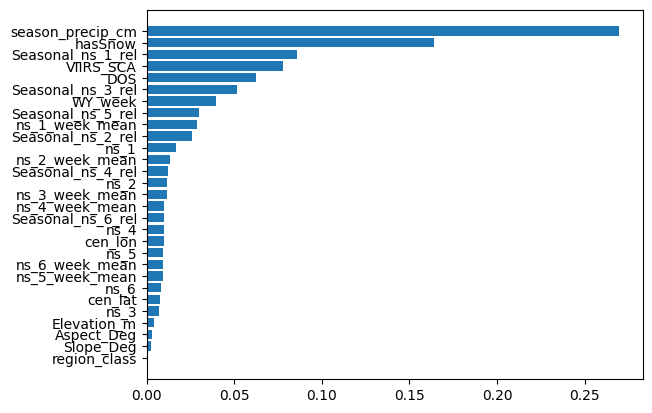

Saving Model
Run is Done!Run Time: 33922.34098172188 seconds 
Model Predictions complete
1000


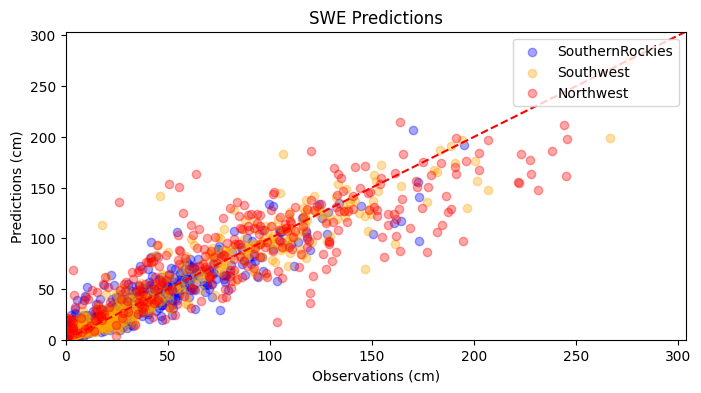

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.93,13.0,47.28,0.06
0,SouthernRockies,0.93,9.0,52.44,-0.71
0,Southwest,0.96,11.0,43.38,-0.14
0,Northwest,0.91,18.0,46.03,0.84


In [11]:
#Train model
tries = 1 #what is tries?
hyperparameters = {
    'max_depth': range (2, 11, 2),
    'n_estimators': range(100, 1001, 200),
    'eta': [0.1,]
}
perc_data = 0.25 # percent of training data used to identify optimial hyperparameters

Use_fSCA_Threshold = True

xgb_model.XGB_Train(model_path, 
                    input_columns, 
                    x_train, 
                    y_train, 
                    tries, 
                    hyperparameters,
                    perc_data)

#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
PredsDF = pd.DataFrame()
PredsDF = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test,
                    y_test,
                    Use_fSCA_Threshold
                    )

#Take a sample to determine model skill - Take 1000 from each modeling domain
n_samples = 1000
SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)

 #Evaluate model performance of the different models
prediction_columns = [f"{modelname}_swe_cm"]
Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                SampleDF,
                                prediction_columns, 
                                modelname, 
                                plots = False, 
                                keystats = False        
                                )